# Deep Learning Project: Pet Classifier using CNN

Data Set


    This is a small program with 25k images of cats and dogs.
    The evaluation set has 12.5k images of cats and dogs
Runs

The student is expected to run the 500 training step


# Import Modules

In [14]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

TRAIN_DIR = 'E:/study/Class/Jacob/Projects/Shashi/data/train'
TEST_DIR = 'E:/study/Class/Jacob/Projects/Shashi/data/test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


# Spliting Cat & Dog Images
Now, our first order of business is to convert the images and labels to array information that we can pass through our network. To do this, we'll need a helper function to convert the image name to an array.

Our images are labeled like "cat.1" or "dog.3" and so on, so we can just split out the dog/cat, and then convert to an array like so

In [10]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

# Creating Tarining image into array
Now, we can build another function to fully process the training images and their labels into arrays:
The tqdm module is a really nice, pretty, way to measure where you are in a process, rather than printing things out at intervals...etc, it gives a progress bar. Super neat.

Anyway, the above function converts the data for us into array data of the image and its label.
 
When we've gone through all of the images, we shuffle them, then save. Shuffle modifies a variable in place, so there's no need to re-define it here.

With this function, we will both save, and return the array data. This way, if we just change the neural network's structure, and not something with the images, like image size..etc..then we can just load the array file and save some processing time. While we're here, we might as well also make a function to process the testing data. This is the actual competition test data, NOT the data that we'll use to check the accuracy of our algorithm as we test. This data has no label.

In [11]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

# Creating Test image into array

In [12]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data


100%|████████████████████████████████████| 25000/25000 [04:59<00:00, 83.54it/s]


# Now we can run the training:

In [ ]:
#Now we can run the training
#train_data = create_train_data()

# If you have already created the dataset:
train_data = np.load('train_data.npy')

# Creating CNN Model
What we have here is a nice, 2 layered convolutional neural network, with a fully connected layer, and then the output layer. It's been debated whether or not a fully connected layer is of any use. I'll leave it in anyway.

This exact convnet was good enough for recognizing hand 28x28 written digits. Let's see how it does with cats and dogs at 50x50 resolution

In [15]:
import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


# Reload the model if already saved

In [31]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')
    
#Now, let's split out training and testing data:

train = train_data[:-500]
test = train_data[-500:]

INFO:tensorflow:Restoring parameters from E:\study\Class\Jacob\Projects\Shashi\dogsvscats-0.001-2conv-basic.model
model loaded!


# Creating Data array
Now, the training data and testing data are both labeled datasets. The training data is what we'll fit the neural network with, and the test data is what we're going to use to validate the results. The test data will be "out of sample," meaning the testing data will only be used to test the accuracy of the network, not to train it.

We also have "test" images that we downloaded. THOSE images are not labeled at all, and those are what we'll submit to Kaggle for the competition.

In [35]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]


# Fit Model
epoch=8

In [32]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3063  | total loss: 0.37296 | time: 876.158s
| Adam | epoch: 008 | loss: 0.37296 - acc: 0.8235 -- iter: 24448/24500
Training Step: 3064  | total loss: 0.35808 | time: 879.264s
| Adam | epoch: 008 | loss: 0.35808 - acc: 0.8380 | val_loss: 0.46252 - val_acc: 0.7820 -- iter: 24500/24500
--


# Saving trainned model

In [33]:
model.save(MODEL_NAME)

INFO:tensorflow:E:\study\Class\Jacob\Projects\Shashi\dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


# Visual inspection of unlabled data

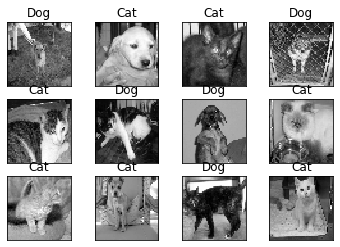

In [34]:
import matplotlib.pyplot as plt

# if you need to create the data:
#test_data = process_test_data()

# if you already have some saved:
test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()